# Yamagawa

- 70-9000 MHz
- 31.25kHz (70-1024 MHz) or 1000 kHz (1024-9000MHz)
- 8 ms

画像を保存しました: output_images/20220613_030000_20220613_033059_70-1024MHz.png


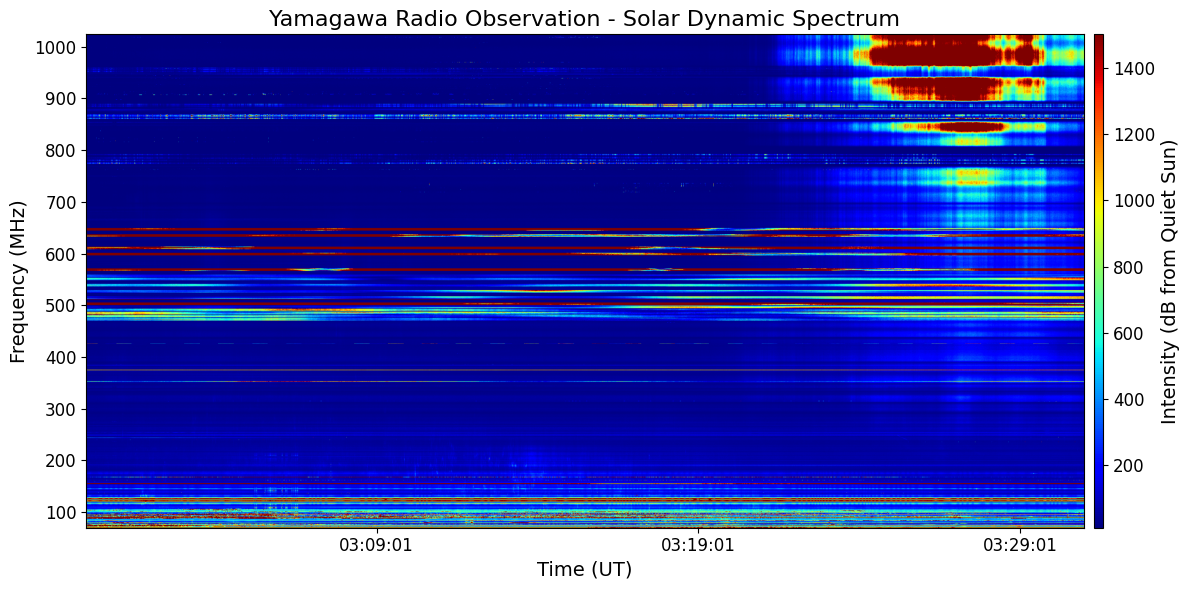

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from astropy.io import fits
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# FITSファイルのパス
fits_file = "/home/kinno-7010/Research/Radio data/Yamagawa/Raw data/YAMAGAWA_2022061303L.fits"  # ファイル名を適宜変更してください

def load_fits_data(fits_file):
    """FITSファイルを読み込んで、データとヘッダーを取得する"""
    with fits.open(fits_file) as hdul:
        data = hdul[0].data  # データ部分。形状は (周波数, 時間)
        header = hdul[0].header  # ヘッダー情報
    return data, header

def generate_time_axis(header):
    """時間軸を作成（8 msec 分解能）"""
    start_time = pd.Timestamp(f"{header['DATE-OBS']} {header['TIME-OBS']}")
    num_points = header['NAXIS1']  # 時間方向のデータ数（通常、NAXIS1 が時間軸）
    time_step = pd.to_timedelta(8, unit='ms')  # 8ミリ秒ステップ
    return np.array([start_time + i * time_step for i in range(num_points)])

def generate_frequency_axis(header):
    """
    周波数軸を作成
    FITSデータの周波数チャンネル数に合わせ、ヘッダーにキャリブレーション情報があれば利用する。
    ヘッダーに 'CRVAL2'（開始周波数）と 'CDELT2'（チャンネル幅）がある場合はそれを使い、
    なければデフォルトで70～9000 MHzの範囲を等間隔に生成する。
    """
    n_freq = header.get('NAXIS2', None)
    if n_freq is None:
        raise ValueError("ヘッダーに 'NAXIS2' がありません。FITSファイルの形式を確認してください。")
    
    if 'CRVAL2' in header and 'CDELT2' in header:
        freq_axis = header['CRVAL2'] + np.arange(n_freq) * header['CDELT2']
    else:
        freq_axis = np.linspace(70, 9000, n_freq)
    return freq_axis

def plot_dynamic_spectrum(fits_file, start_time, end_time, min_frequency, max_frequency, 
                          xticks_interval, yticks_interval, vmin=None, vmax=None):
    """ダイナミックスペクトルをプロットする"""
    # FITSデータの読み込み
    data, header = load_fits_data(fits_file)

    # 時間軸と周波数軸の生成
    time_axis = generate_time_axis(header)      # 長さは header['NAXIS1']
    freq_axis = generate_frequency_axis(header)   # 長さは header['NAXIS2']

    # 時間と周波数の範囲を制限
    time_mask = (time_axis >= start_time) & (time_axis <= end_time)
    freq_mask = (freq_axis >= min_frequency) & (freq_axis <= max_frequency)

    # データをトリミング
    # FITSデータは (周波数, 時間) の形状と仮定
    trimmed_data = data[freq_mask, :][:, time_mask]
    trimmed_time_axis = time_axis[time_mask]
    trimmed_freq_axis = freq_axis[freq_mask]

    # プロットの作成
    fig, ax = plt.subplots(figsize=(12, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)

    # imshow の extent を、引数で指定された start_time, end_time と
    # 選択した周波数範囲から設定
    extent = [
        mdates.date2num(start_time),      # x軸の開始（引数 start_time を使用）
        mdates.date2num(end_time),        # x軸の終了（引数 end_time を使用）
        trimmed_freq_axis[0],
        trimmed_freq_axis[-1]
    ]

    # vmin/vmax をデータのパーセンタイルで自動設定（未指定時）
    if vmin is None:
        vmin = np.percentile(trimmed_data, 5)
    if vmax is None:
        vmax = np.percentile(trimmed_data, 95)

    img = ax.imshow(trimmed_data, aspect='auto', origin='lower', extent=extent,
                    cmap='jet', vmin=vmin, vmax=vmax)

    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Intensity (dB from Quiet Sun)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax.set_xlabel('Time (UT)', fontsize=14)
    ax.set_ylabel('Frequency (MHz)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title('Yamagawa Radio Observation - Solar Dynamic Spectrum', fontsize=16)

    # 時間軸のフォーマット設定（UT 時間）
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim(mdates.date2num(start_time), mdates.date2num(end_time))
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=xticks_interval))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(yticks_interval))
    
    # 画像保存用フォルダの設定
    output_folder = "output_images"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    start_str = start_time.strftime("%Y%m%d_%H%M%S")
    end_str = end_time.strftime("%Y%m%d_%H%M%S")
    output_filename = os.path.join(output_folder, f"{start_str}_{end_str}_{min_frequency}-{max_frequency}MHz.png")
    plt.savefig(output_filename, dpi=300)
    print(f"画像を保存しました: {output_filename}")

    plt.tight_layout()
    plt.show()

# **プロットを実行**
plot_dynamic_spectrum(
    fits_file,
    start_time=pd.Timestamp("2022-06-13T03:00:00"),
    end_time=pd.Timestamp("2022-06-13T03:30:59"), 
    min_frequency=70,
    max_frequency=1024, 
    xticks_interval=60*10,  # 例：60秒ごとに目盛り
    yticks_interval=100
)


/tmp/ipykernel_55835/1587705449.py:102: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  tick_times = pd.date_range(start=trimmed_time_axis[0],


画像を保存しました: output_images/20220613_030000_20220613_033059_70-1024MHz.png


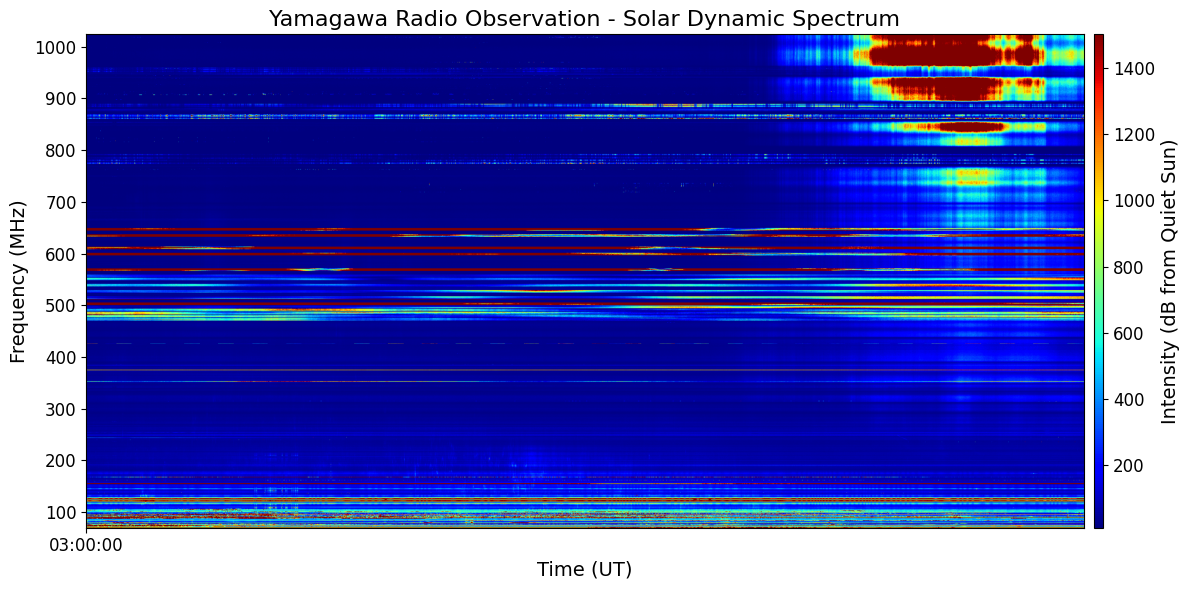

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from astropy.io import fits
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# FITSファイルのパス
fits_file = "/home/kinno-7010/Research/Radio data/Yamagawa/Raw data/YAMAGAWA_2022061303L.fits"  # ファイル名を適宜変更してください

def load_fits_data(fits_file):
    """FITSファイルを読み込んで、データとヘッダーを取得する"""
    with fits.open(fits_file) as hdul:
        data = hdul[0].data  # データ部分。形状は (周波数, 時間)
        header = hdul[0].header  # ヘッダー情報
    return data, header

def generate_time_axis(header):
    """時間軸を作成（8 msec 分解能）"""
    start_time = pd.Timestamp(f"{header['DATE-OBS']} {header['TIME-OBS']}")
    num_points = header['NAXIS1']  # 時間方向のデータ数（通常、NAXIS1 が時間軸）
    time_step = pd.to_timedelta(8, unit='ms')  # 8ミリ秒ステップ
    return np.array([start_time + i * time_step for i in range(num_points)])

def generate_frequency_axis(header):
    """
    周波数軸を作成
    FITSデータの周波数チャンネル数に合わせ、ヘッダーにキャリブレーション情報があれば利用する。
    ヘッダーに 'CRVAL2'（開始周波数）と 'CDELT2'（チャンネル幅）がある場合はそれを使い、
    なければデフォルトで70～9000 MHzの範囲を等間隔に生成する。
    """
    n_freq = header.get('NAXIS2', None)
    if n_freq is None:
        raise ValueError("ヘッダーに 'NAXIS2' がありません。FITSファイルの形式を確認してください。")
    
    if 'CRVAL2' in header and 'CDELT2' in header:
        freq_axis = header['CRVAL2'] + np.arange(n_freq) * header['CDELT2']
    else:
        freq_axis = np.linspace(70, 9000, n_freq)
    return freq_axis

def plot_dynamic_spectrum(fits_file, start_time, end_time, min_frequency, max_frequency, 
                          xticks_interval, yticks_interval, vmin=None, vmax=None):
    """ダイナミックスペクトルをプロットする"""
    # FITSデータの読み込み
    data, header = load_fits_data(fits_file)

    # 時間軸と周波数軸の生成
    time_axis = generate_time_axis(header)      # 長さは header['NAXIS1']
    freq_axis = generate_frequency_axis(header)   # 長さは header['NAXIS2']

    # 時間と周波数の範囲を制限
    time_mask = (time_axis >= start_time) & (time_axis <= end_time)
    freq_mask = (freq_axis >= min_frequency) & (freq_axis <= max_frequency)

    # データをトリミング
    # FITSデータは (周波数, 時間) の形状と仮定
    trimmed_data = data[freq_mask, :][:, time_mask]
    trimmed_time_axis = time_axis[time_mask]
    trimmed_freq_axis = freq_axis[freq_mask]

    # プロットの作成
    fig, ax = plt.subplots(figsize=(12, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)

    # imshow の extent を、トリミングされた時間軸と周波数軸から設定
    extent = [
        mdates.date2num(trimmed_time_axis[0]),
        mdates.date2num(trimmed_time_axis[-1]),
        trimmed_freq_axis[0],
        trimmed_freq_axis[-1]
    ]

    # vmin/vmax をデータのパーセンタイルで自動設定（未指定時）
    if vmin is None:
        vmin = np.percentile(trimmed_data, 5)
    if vmax is None:
        vmax = np.percentile(trimmed_data, 95)

    img = ax.imshow(trimmed_data, aspect='auto', origin='lower', extent=extent,
                    cmap='jet', vmin=vmin, vmax=vmax)

    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Intensity (dB from Quiet Sun)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax.set_xlabel('Time (UT)', fontsize=14)
    ax.set_ylabel('Frequency (MHz)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title('Yamagawa Radio Observation - Solar Dynamic Spectrum', fontsize=16)

    # 時間軸のフォーマット設定（UT 時間）
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    
    # トリミングされた時間軸に合わせた x 軸の範囲
    ax.set_xlim(mdates.date2num(trimmed_time_axis[0]), mdates.date2num(trimmed_time_axis[-1]))

    # 目盛を明示的に設定する（xticks_interval は秒単位）
    tick_times = pd.date_range(start=trimmed_time_axis[0],
                               end=trimmed_time_axis[-1],
                               freq=f"{xticks_interval}s")
    ax.set_xticks(mdates.date2num(tick_times))

    # y 軸の目盛は MultipleLocator で設定
    ax.yaxis.set_major_locator(mticker.MultipleLocator(yticks_interval))
    
    # 画像保存用フォルダの設定
    output_folder = "output_images"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    start_str = start_time.strftime("%Y%m%d_%H%M%S")
    end_str = end_time.strftime("%Y%m%d_%H%M%S")
    output_filename = os.path.join(output_folder, f"{start_str}_{end_str}_{min_frequency}-{max_frequency}MHz.png")
    plt.savefig(output_filename, dpi=300)
    print(f"画像を保存しました: {output_filename}")

    plt.tight_layout()
    plt.show()

# **プロットを実行**
plot_dynamic_spectrum(
    fits_file,
    start_time=pd.Timestamp("2022-06-13T03:00:00"),
    end_time=pd.Timestamp("2022-06-13T03:30:59"), 
    min_frequency=70,
    max_frequency=1024, 
    xticks_interval=60*10,  # 10分間隔（600秒）
    yticks_interval=100
)


(8930, 3600)
画像を保存しました: output_images/20220613_034000_20220613_050000_1000-9000MHz.png


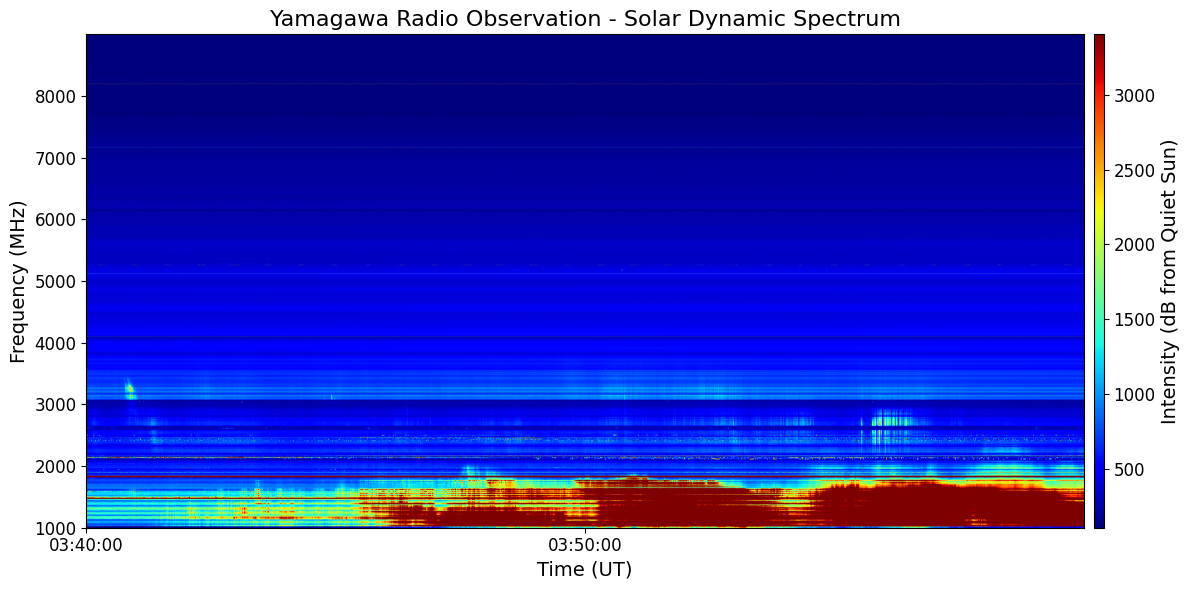

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from astropy.io import fits
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# FITSファイルのパス（適宜変更してください）
fits_file = "/home/kinno-7010/Research/Radio data/Yamagawa/Raw data/YAMAGAWA_2022061303L.fits"

def load_fits_data(fits_file):
    """FITSファイルを読み込んで、データとヘッダーを取得する"""
    with fits.open(fits_file) as hdul:
        data = hdul[0].data  # データ部分。形状は (周波数, 時間) と仮定
        header = hdul[0].header  # ヘッダー情報
    return data, header

def generate_time_axis(header):
    """
    時間軸を作成（今回の山川データは1秒分解能）
    ヘッダーの 'DATE-OBS' と 'TIME-OBS' を開始時刻として利用．
    ヘッダーの NAXIS1 が時間方向のデータ数であると仮定
    """
    # 例：'DATE-OBS' = "2022-06-13", 'TIME-OBS' = "03:00:00"
    start_time = pd.Timestamp(f"{header['DATE-OBS']} {header['TIME-OBS']}")
    num_points = header['NAXIS1']  # 時間方向のデータ数（例：3600 → 1時間分）
    time_step = pd.to_timedelta(1, unit='s')  # 1秒間隔
    return np.array([start_time + i * time_step for i in range(num_points)])

def generate_frequency_axis(header):
    """
    周波数軸を作成．
    ヘッダーに 'CRVAL2'（開始周波数）と 'CDELT2'（チャンネル幅）があればそれを使い，
    なければ 70～9000 MHz の範囲を等間隔に生成する．
    """
    n_freq = header.get('NAXIS2', None)
    if n_freq is None:
        raise ValueError("ヘッダーに 'NAXIS2' がありません。FITSファイルの形式を確認してください。")
    
    if 'CRVAL2' in header and 'CDELT2' in header:
        freq_axis = header['CRVAL2'] + np.arange(n_freq) * header['CDELT2']
    else:
        freq_axis = np.linspace(70, 9000, n_freq)
    return freq_axis

def plot_dynamic_spectrum(fits_file, start_time, end_time, min_frequency, max_frequency, 
                          xticks_interval, yticks_interval, vmin=None, vmax=None):
    """ダイナミックスペクトルをプロットする"""
    # FITSデータの読み込み
    data, header = load_fits_data(fits_file)
    print(data.shape)

    # 時間軸と周波数軸の生成
    time_axis = generate_time_axis(header)      # 長さは header['NAXIS1']
    freq_axis = generate_frequency_axis(header)   # 長さは header['NAXIS2']

    # 指定した時間と周波数の範囲でマスクを作成
    time_mask = (time_axis >= start_time) & (time_axis <= end_time)
    freq_mask = (freq_axis >= min_frequency) & (freq_axis <= max_frequency)

    # データをトリミング（FITSデータは (周波数, 時間) の形状と仮定）
    trimmed_data = data[freq_mask, :][:, time_mask]
    trimmed_time_axis = time_axis[time_mask]
    trimmed_freq_axis = freq_axis[freq_mask]

    # プロットの作成
    fig, ax = plt.subplots(figsize=(12, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)

    # imshow の extent を，トリミングされた時間軸と周波数軸から設定
    extent = [
        mdates.date2num(trimmed_time_axis[0]),
        mdates.date2num(trimmed_time_axis[-1]),
        trimmed_freq_axis[0],
        trimmed_freq_axis[-1]
    ]

    # vmin/vmax をデータのパーセンタイルで自動設定（未指定の場合）
    if vmin is None:
        vmin = np.percentile(trimmed_data, 5)
    if vmax is None:
        vmax = np.percentile(trimmed_data, 95)

    img = ax.imshow(trimmed_data, aspect='auto', origin='lower', extent=extent,
                    cmap='jet', vmin=vmin, vmax=vmax)

    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Intensity (dB from Quiet Sun)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax.set_xlabel('Time (UT)', fontsize=14)
    ax.set_ylabel('Frequency (MHz)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title('Yamagawa Radio Observation - Solar Dynamic Spectrum', fontsize=16)

    # 時間軸のフォーマット設定（HH:MM:SS 表示）
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    # x軸の範囲を設定
    ax.set_xlim(mdates.date2num(trimmed_time_axis[0]), mdates.date2num(trimmed_time_axis[-1]))

    # xticks_interval（秒単位）に合わせて目盛を設定
    # pd.date_range では，freq パラメータに文字列で秒数を指定可能（例："600s"）
    tick_times = pd.date_range(start=trimmed_time_axis[0],
                               end=trimmed_time_axis[-1],
                               freq=f"{xticks_interval}s")
    ax.set_xticks(mdates.date2num(tick_times))

    # y軸の目盛は MultipleLocator を利用
    ax.yaxis.set_major_locator(mticker.MultipleLocator(yticks_interval))
    
    # 画像保存用フォルダの設定
    output_folder = "output_images"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    start_str = start_time.strftime("%Y%m%d_%H%M%S")
    end_str = end_time.strftime("%Y%m%d_%H%M%S")
    output_filename = os.path.join(output_folder, f"{start_str}_{end_str}_{min_frequency}-{max_frequency}MHz.png")
    plt.savefig(output_filename, dpi=300)
    print(f"画像を保存しました: {output_filename}")

    plt.tight_layout()
    plt.show()

# **プロットの実行**
plot_dynamic_spectrum(
    fits_file,
    start_time=pd.Timestamp("2022-06-13T03:40:00"),
    end_time=pd.Timestamp("2022-06-13T05:00:00"), 
    min_frequency=1000,
    max_frequency=9000, 
    xticks_interval=600,  # 600秒 = 10分間隔
    yticks_interval=1000,
    vmin=None,
    vmax=None
)
